In [1]:
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3, MobileNetV2, DenseNet121, NASNetMobile
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import models, layers, metrics
from google.colab import drive
from sklearn.utils import shuffle
import zipfile
import pandas as pd
import keras
import h5py
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math
import gc
import seaborn as sns
import time
pd.set_option('display.max_colwidth', None)  # Define para exibir todo o conteúdo das colunas
pd.set_option('display.expand_frame_repr', False)  # Impede a quebra de linha ao exibir DataFrame

In [3]:
def montar_google_drive():
    drive.mount('/content/drive', force_remount=True)
    pd.set_option("display.max_rows", None)

def descompactar_arquivos():

    !cp "/content/drive/MyDrive/00-TCC/hursat/images.npy" "/content/"
    !cp "/content/drive/MyDrive/00-TCC/hursat/labels.npy" "/content/"

    !cp "/content/drive/MyDrive/00-TCC/hursat/hursat_hurdat100.rar" "/content/"
    !unrar x "/content/hursat_hurdat100.rar" "/content" > /dev/null 2>&1
    !cp "/content/drive/MyDrive/00-TCC/hursat/dataset-hursat-hurdat100.csv" "/content/"

In [4]:
montar_google_drive()
descompactar_arquivos()

Mounted at /content/drive


In [5]:
tamanho = 100
dados = pd.read_csv('/content/dataset-hursat-hurdat100.csv')
dados = dados.drop(columns=['wind_category'])
dados.loc[:, 'year'] = dados['id'].str[4:8]
dados.loc[:, 'year'] = pd.to_numeric(dados['year'])


def extrair_satelite(path):
    try:
        arquivo = path.split('/')[-1]
        satelite = arquivo.split('.')[7]
        return satelite
    except IndexError:
        return None


dados.loc[:, 'basin'] = dados['id'].str[:2]
dados.loc[:, 'satellite'] = dados['path'].apply(extrair_satelite)

In [6]:
dados_treino = dados[:12550]
dados_treino.reset_index(drop=True, inplace=True)
dados_teste = dados[12650:15766]
dados_teste.reset_index(drop=True, inplace=True)
print(dados_treino.shape)
print(dados_teste.shape)

(12550, 6)
(3116, 6)


In [7]:
def processa_h5(h5_path, crop_height=None, crop_width=None):
    with h5py.File(h5_path, 'r') as f:
        image = np.array(f['IRWIN'], dtype=np.float32)

    if crop_height and crop_width:
        height, width = image.shape
        start_row = (height - crop_height) // 2
        start_col = (width - crop_width) // 2
        image = image[start_row:start_row+crop_height, start_col:start_col+crop_width]

    return image

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Função para verificar se a imagem contém pixels negativos
def verificar_pixels_negativos(img):
    return np.any(img < 1)

# Função para calcular o Z-score de cada imagem e filtrar as imagens ruidosas
def calcular_z_score(medias, threshold=3):
    mean_total = np.mean(medias)
    std_total = np.std(medias)
    z_scores = np.abs((medias - mean_total) / std_total)
    return z_scores > threshold



def filtrar_imagens(dataframe, threshold=3):
    imagens = []
    medias = []
    indices_remover = []


    for idx, row in dataframe.iterrows():
        img = processa_h5(row['path'], tamanho, tamanho)
        imagens.append(img)
        medias.append(np.mean(img))


        if verificar_pixels_negativos(img):
            indices_remover.append(idx)


    imagens = np.array(imagens)
    medias = np.array(medias)


    z_scores = calcular_z_score(medias, threshold=threshold)


    for i, score in enumerate(z_scores):
        if score:
            indices_remover.append(i)


    indices_remover = sorted(set(indices_remover))


    dataframe_filtrado = dataframe.drop(indices_remover).reset_index(drop=True)

    imagens_filtradas = imagens[indices_remover]

    print(f"Imagens filtradas: {len(imagens_filtradas)}")

    return imagens_filtradas, dataframe_filtrado


def exibir_imagens_filtradas(dataframe, imagens, num_images=100):
    num_images = min(num_images, len(imagens))
    plt.figure(figsize=(30, 30))

    for i in range(num_images):
        wind_label = dataframe['wind'].iloc[i]
        index = dataframe.index[i]
        img = imagens[i]

        plt.subplot(10, 10, i + 1)
        plt.imshow(img.squeeze(), cmap='gray')
        plt.title(f'Index: {index}\nWind: {wind_label}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


print('Conjunto de treino')
imagens_filtradas, dados_treino = filtrar_imagens(dados_treino, threshold=3)
exibir_imagens_filtradas(dados_treino, imagens_filtradas, num_images=100)

print('Conjunto de teste')
imagens_filtradas, dados_teste = filtrar_imagens(dados_teste, threshold=3)
exibir_imagens_filtradas(dados_teste, imagens_filtradas, num_images=100)


In [ ]:
#Análise Exploratória de Dados (EDA)

In [ ]:
dados_concatenados = pd.concat([dados_treino, dados_teste], ignore_index=True)

In [ ]:
plt.figure(figsize=(8, 5))
plt.hist(dados_concatenados['wind'], bins=27, edgecolor='black')
plt.title('Distribuição das Velocidades dos Vento')
plt.xlabel('Velocidades do Vento')
plt.ylabel('Frequência')
plt.show()

In [ ]:
dados_concatenados['wind'].describe()

In [ ]:
ciclones_por_bacia = dados_concatenados.groupby('basin')['id'].nunique()
ciclones_por_bacia = ciclones_por_bacia.sort_values(ascending=False)
cor_azul_escuro = '#1f77b4'

plt.figure(figsize=(8, 6))
ax = ciclones_por_bacia.plot(kind='bar', color=cor_azul_escuro, edgecolor='black')

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=11, color='black')

plt.title('Distribuição de Ciclones por Bacia', fontsize=14, weight='bold')
plt.xlabel('Bacia', fontsize=12)
plt.ylabel('Quantidade de Ciclones', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
quantidade_ciclones = dados['id'].nunique()
print(f'Número de ciclones únicos: {quantidade_ciclones}')

In [ ]:
def salvar_imagens_e_rotulos(dataframe, crop_height, crop_width,save_path_images,save_path_labels):
    images = []
    image_paths = dataframe['path']
    wind_speeds = dataframe['wind']

    for path in image_paths:
        img = processa_h5(path, crop_height, crop_width)
        img = img.reshape((crop_height, crop_width, 1))
        images.append(img)

    imagens = np.array(images)
    rotulos = np.array(wind_speeds)

    np.save(save_path_images, imagens)
    np.save(save_path_labels, rotulos)

    print(f"Imagens salvas em: {save_path_images}")
    print(f"Rótulos salvos em: {save_path_labels}")

salvar_imagens_e_rotulos(dados_treino,tamanho,tamanho,'/content/drive/MyDrive/00-TCC/hursat/arrays/imagens_treino.npy', '/content/drive/MyDrive/00-TCC/hursat/arrays/rotulos_treino.npy')

salvar_imagens_e_rotulos(dados_teste,tamanho,tamanho,'/content/drive/MyDrive/00-TCC/hursat/arrays/imagens_teste.npy', '/content/drive/MyDrive/00-TCC/hursat/arrays/rotulos_teste.npy')


In [6]:
imagens_treino = np.load('/content/drive/MyDrive/00-TCC/hursat/arrays/imagens_treino.npy')
rotulos_treino = np.load('/content/drive/MyDrive/00-TCC/hursat/arrays/rotulos_treino.npy')

imagens_teste = np.load('/content/drive/MyDrive/00-TCC/hursat/arrays/imagens_teste.npy')
rotulos_teste = np.load('/content/drive/MyDrive/00-TCC/hursat/arrays/rotulos_teste.npy')

In [7]:
def show_progress(action, progress, total):
    """
    Mostra o progresso de uma ação em porcentagem no terminal.

    """
    percent_progress = round((progress / total) * 100, 1)
    print(f'\r{action}... {percent_progress}% ({progress} of {total})', end='')

def normaliza_dados(train_images, test_images):
    """
    Normaliza as imagens de treino e teste com base na média e desvio padrão das imagens de treino.

    """
    train_images = np.maximum(train_images, 0)  # Trunca valores negativos
    test_images = np.maximum(test_images, 0)

    mean = np.mean(train_images)
    st_dev = np.std(train_images)

    train_images = (train_images - mean) / st_dev
    test_images = (test_images - mean) / st_dev

    return train_images, test_images

In [8]:
def prepara_dados(validation_mode, k=5, augment=True):
    """
    Prepara os dados para treino e validação. Utiliza K-fold se o modo de validação for 'k_fold'.

    """
    if validation_mode != 'k_fold':
        raise ValueError("Invalid validation_mode. Supported mode: 'k_fold'")

    images, labels = shuffle(imagens_treino, rotulos_treino, random_state=42)

    folded_images, folded_labels = split_data_into_folds(images, labels, k)

    if augment:
        folded_augmented_images, folded_augmented_labels = augment_folds(folded_images, folded_labels, k)
    else:
        folded_augmented_images, folded_augmented_labels = folded_images, folded_labels

    train_images, train_labels, test_images, test_labels = prepare_train_test_data(
        folded_images, folded_labels, folded_augmented_images, folded_augmented_labels, k, augment
    )

    return train_images, train_labels, test_images, test_labels


def split_data_into_folds(images, labels, k):
    """
    Divide os dados em k folds.

    """
    folded_images, folded_labels = [], []
    fold_size = len(images) // k
    for i in range(k):
        start, end = i * fold_size, (i + 1) * fold_size
        folded_images.append(images[start:end])
        folded_labels.append(labels[start:end])
    return folded_images, folded_labels


def augment_folds(folded_images, folded_labels, k):

    folded_augmented_images, folded_augmented_labels = [], []
    for i in range(k):
        print(f'\nAugmenting Fold {i + 1} of {k}')
        augmented_images, augmented_labels = augment_images(folded_images[i], folded_labels[i])
        folded_augmented_images.append(augmented_images)
        folded_augmented_labels.append(augmented_labels)
    return folded_augmented_images, folded_augmented_labels


def prepare_train_test_data(folded_images, folded_labels, augmented_images, augmented_labels, k, augment):
    """
    Prepara os dados de treino e teste com ou sem augmentação.

    """
    train_images, train_labels, test_images, test_labels = [], [], [], []

    for i in range(k):
        current_train_images = np.concatenate(folded_images[:i] + folded_images[i+1:])
        current_train_labels = np.concatenate(folded_labels[:i] + folded_labels[i+1:])

        if augment:
            current_train_images = np.concatenate([current_train_images] + augmented_images[:i] + augmented_images[i+1:])
            current_train_labels = np.concatenate([current_train_labels] + augmented_labels[:i] + augmented_labels[i+1:])

        train_images.append(current_train_images)
        train_labels.append(current_train_labels)
        test_images.append(folded_images[i])
        test_labels.append(folded_labels[i])

        train_images[i], test_images[i] = normaliza_dados(train_images[i], test_images[i])

    return train_images, train_labels, test_images, test_labels


def augment_images(images, labels):
    """
    Realiza a augmentação das imagens e retorna imagens augmentadas e seus rótulos.

    Parameters:
    images (ndarray): Conjunto de imagens a serem augmentadas.
    labels (ndarray): Conjunto de rótulos correspondentes às imagens.

    Returns:
    Tuple: Imagens augmentadas e rótulos augmentados.
    """
    augmented_images, augmented_labels = [], []

    # Geração de augmentação
    rotate_generator = ImageDataGenerator(rotation_range=360)

    for i, (image, label) in enumerate(zip(images, labels)):
        # Garantindo que a imagem tenha formato 4D (batch_size, height, width, channels)
        if len(image.shape) == 2:  # Se a imagem for 2D (height, width)
            image = np.expand_dims(image, axis=-1)  # Adiciona o canal (grayscale)
        image = np.expand_dims(image, axis=0)  # Adiciona a dimensão do batch

        if label > 100:
            num_new_images = 0
            for batch in rotate_generator.flow(image, batch_size=1):
                # Garante que estamos lidando com um array de 4 dimensões
                new_image = batch[0]
                if new_image.ndim == 4 and new_image.shape[0] == 1:
                    new_image = new_image[0]  # Remove a dimensão do batch se necessário

                augmented_images.append(new_image)
                augmented_labels.append(label)
                num_new_images += 1
                if num_new_images == 2:
                    break

        show_progress('Augmenting Images', i + 1, len(images))

    return np.array(augmented_images), np.array(augmented_labels)


In [9]:
def performance_epoca(performance_log):
    """
    Plota o gráfico de loss (erro) de treino e validação ao longo das épocas.

    """
    train_loss = performance_log.history['loss']
    test_loss = performance_log.history['val_loss']
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(epochs, train_loss, label='Treino', color='blue', linewidth=2, marker='o', markersize=5)
    plt.plot(epochs, test_loss, label='Validação', color='orange', linewidth=2, marker='o', markersize=5)
    plt.title('Loss x Épocas', fontsize=14, weight='bold')
    plt.xlabel('Épocas', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

def gera_predicao(model, test_images, test_labels):
    """
    Gera previsões do modelo e calcula erros absolutos e categóricos para avaliação.

    """
    raw_predictions = model.predict(test_images).flatten()

    processed_predictions = pd.DataFrame({
        'prediction': raw_predictions,
        'actual': test_labels,
        'abs_error': np.abs(raw_predictions - test_labels),
        'abs_error_squared': np.square(np.abs(raw_predictions - test_labels))
    })

    return processed_predictions

In [10]:
def avalia(model, num_of_fold, x_val, y_val):
    """
    Avalia o modelo, imprime as métricas e salva o modelo.

    """
    score = model.evaluate(x_val, y_val, verbose=0)
    print(f'Val loss: {score[0]:.4f} Val MAE: {score[1]:.4f} Val RMSE: {score[2]:.4f}')

    Loss.append(score[0])
    MAE.append(score[1])
    RMSE.append(score[2])

    output_name = f'/content/drive/MyDrive/00-TCC/hursat/teste/{num_of_fold + 1}_fold_model.keras'
    model.save(output_name)
    print(f'Saved: {output_name}')

In [11]:
#Modelo Base

def build_model():

    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(tamanho, tamanho, 1)))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))


    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(1, activation=None))

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        #optimizer='adam',
        loss='mse',
        metrics=[metrics.MeanAbsoluteError(), metrics.RootMeanSquaredError()])

    return model

def train_model(model, train_images, train_labels, test_images, test_labels):

    performance_log = model.fit(
        train_images,
        train_labels,
        callbacks=[EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)],
        epochs=100,
        batch_size=64,
        validation_data=(test_images, test_labels),
        shuffle = True
        )

    performance_epoca(performance_log)

    return model

In [12]:
#Experimento 2


def build_model2():

    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(tamanho, tamanho, 1)))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))


    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(1, activation=None))

    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        #optimizer='adam',
        loss='mse',
        metrics=[metrics.MeanAbsoluteError(), metrics.RootMeanSquaredError()])

    return model

def train_model(model, train_images, train_labels, test_images, test_labels, show_performance_by_epoch=True):

    performance_log = model.fit(
        train_images,
        train_labels,
        callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
        epochs=100,
        batch_size=16,
        validation_data=(test_images, test_labels),
        shuffle = True
        )

    performance_epoca(performance_log)

    return model


Augmenting Fold 1 of 5
Augmenting Images... 100.0% (2352 of 2352)
Augmenting Fold 2 of 5
Augmenting Images... 100.0% (2352 of 2352)
Augmenting Fold 3 of 5
Augmenting Images... 100.0% (2352 of 2352)
Augmenting Fold 4 of 5
Augmenting Images... 100.0% (2352 of 2352)
Augmenting Fold 5 of 5
Augmenting Images... 100.0% (2352 of 2352)

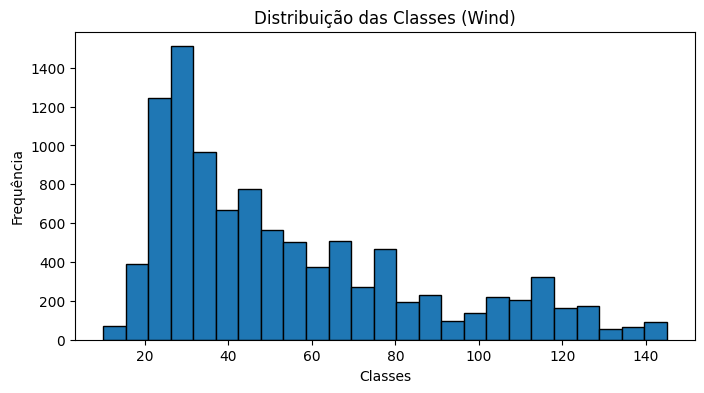

(10274,)
(2807, 100, 100, 1)


In [13]:
train_images, train_labels, val_images, val_labels = prepara_dados('k_fold', 5, augment=True)
Xtrain, test_images = normaliza_dados(imagens_teste, imagens_teste)


plt.figure(figsize=(8, 4))
plt.hist(train_labels[0], bins=25, edgecolor='black')
plt.title('Distribuição das Classes (Wind)')
plt.xlabel('Classes')
plt.ylabel('Frequência')
plt.show()

print(train_labels[0].shape)
print(test_images.shape)



Training Fold 1 of 5



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
643/643 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - loss: 1167.2810 - mean_absolute_error: 26.4000 - root_mean_squared_error: 33.4031 - val_loss: 493.7410 - val_mean_absolute_error: 17.1997 - val_root_mean_squared_error: 22.2203
Epoch 2/100
643/643 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 592.6438 - mean_absolute_error: 19.2453 - root_mean_squared_error: 24.3361 - val_loss: 344.3156 - val_mean_absolute_error: 14.0233 - val_root_mean_squared_error: 18.5557
Epoch 3/100
643/643 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 390.7323 - mean_absolute_error: 15.3699 - root_mean_squared_error: 19.7633 - val_loss: 283.2079 - val_mean_absolute_error: 12.9841 - val_root_mean_squared_error: 16.8288
Epoch 4/100
643/643 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 323.1407 - mean_absolute_error: 13.8749 - root_mean_squared_error: 17.9711 - val_loss: 253.9285 - val_mean_absolute_error: 11.9921 - val_root_mean_squared_error: 15.9351
Epoch 5/100
643/643 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 292.7664 - 

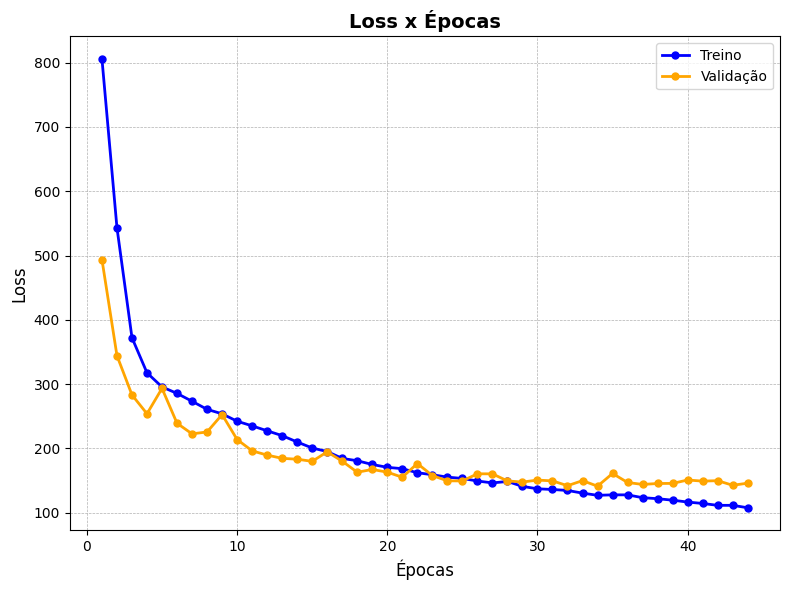

Val loss: 141.3038, Val MAE: 9.0028, Val RMSE: 11.8871
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Saved predictions for fold 1 at /content/drive/MyDrive/00-TCC/hursat/teste/1_pred.csv


Training Fold 2 of 5



<ipython-input-14-96a9363dad91>:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  predictions = pd.concat([predictions, fold_predictions], ignore_index=True)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
643/643 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 1179.1266 - mean_absolute_error: 26.3772 - root_mean_squared_error: 33.5325 - val_loss: 536.9324 - val_mean_absolute_error: 18.3532 - val_root_mean_squared_error: 23.1718
Epoch 2/100
643/643 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - loss: 596.4933 - mean_absolute_error: 19.2094 - root_mean_squared_error: 24.4113 - val_loss: 454.9119 - val_mean_absolute_error: 16.6617 - val_root_mean_squared_error: 21.3287
Epoch 3/100
643/643 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 385.8081 - mean_absolute_error: 15.1563 - root_mean_squared_error: 19.6378 - val_loss: 285.8980 - val_mean_absolute_error: 13.0127 - val_root_mean_squared_error: 16.9085
Epoch 4/100
643/643 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 321.6583 - mean_absolute_error: 13.7836 - root_mean_squared_error: 17.9298 - val_loss: 287.1009 - val_mean_absolute_error: 12.9778 - val_root_mean_squared_error: 16.9441
Epoch 5/100
643/643 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 297.0842 -

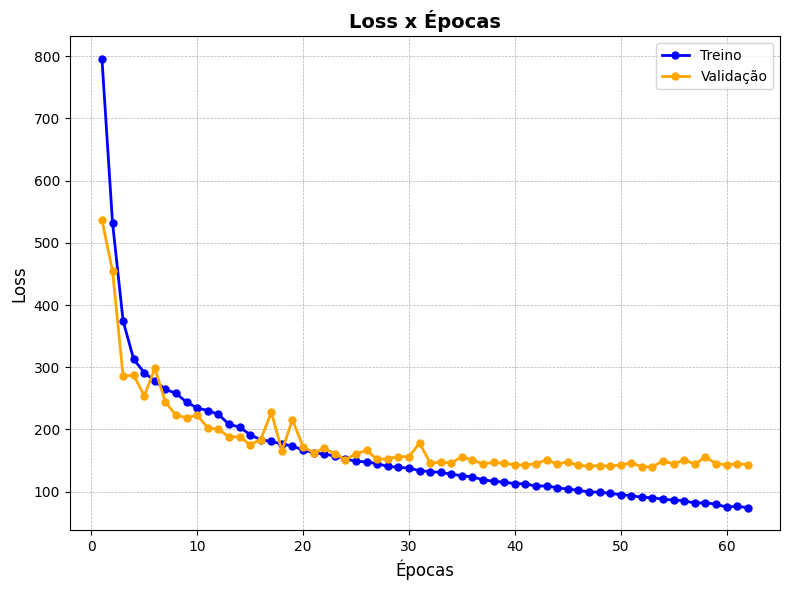

Val loss: 140.0118, Val MAE: 8.9418, Val RMSE: 11.8327
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Saved predictions for fold 2 at /content/drive/MyDrive/00-TCC/hursat/teste/2_pred.csv


Training Fold 3 of 5

Epoch 1/100
643/643 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: 1233.2375 - mean_absolute_error: 26.7220 - root_mean_squared_error: 34.2426 - val_loss: 533.5936 - val_mean_absolute_error: 18.6625 - val_root_mean_squared_error: 23.0996
Epoch 2/100
643/643 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 597.4781 - mean_absolute_error: 19.3018 - root_mean_squared_error: 24.4403 - val_loss: 343.3580 - val_mean_absolute_error: 14.5837 - val_root_mean_squared_error: 18.5299
Epoch 3/100
643/643 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 389.4868 - mean_absolute_error: 15.2845 - root_mean_squared_error: 19.7267 - val_loss: 294.9588 - val_mean_absolute_error: 12.9683 - val_root_mean_squared_error: 17.1744
Epoch 4/100
643/643 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 312.6848 - mean_absolute_error: 13.60

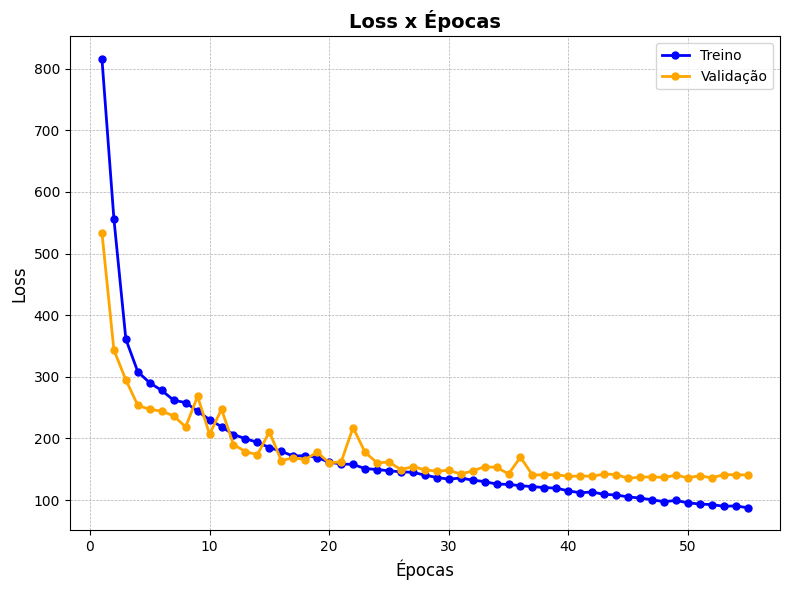

Val loss: 135.2542, Val MAE: 8.9032, Val RMSE: 11.6299
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Saved predictions for fold 3 at /content/drive/MyDrive/00-TCC/hursat/teste/3_pred.csv


Training Fold 4 of 5

Epoch 1/100
645/645 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 1222.8719 - mean_absolute_error: 26.8167 - root_mean_squared_error: 34.1118 - val_loss: 458.6456 - val_mean_absolute_error: 16.7498 - val_root_mean_squared_error: 21.4160
Epoch 2/100
645/645 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - loss: 629.2170 - mean_absolute_error: 19.8559 - root_mean_squared_error: 25.0761 - val_loss: 327.2707 - val_mean_absolute_error: 14.0744 - val_root_mean_squared_error: 18.0906
Epoch 3/100
645/645 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 409.9375 - mean_absolute_error: 15.8654 - root_mean_squared_error: 20.2316 - val_loss: 286.8825 - val_mean_absolute_error: 12.7892 - val_root_mean_squared_error: 16.9376
Epoch 4/100
645/645 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 344.8323 - mean_absolute_error: 14.2

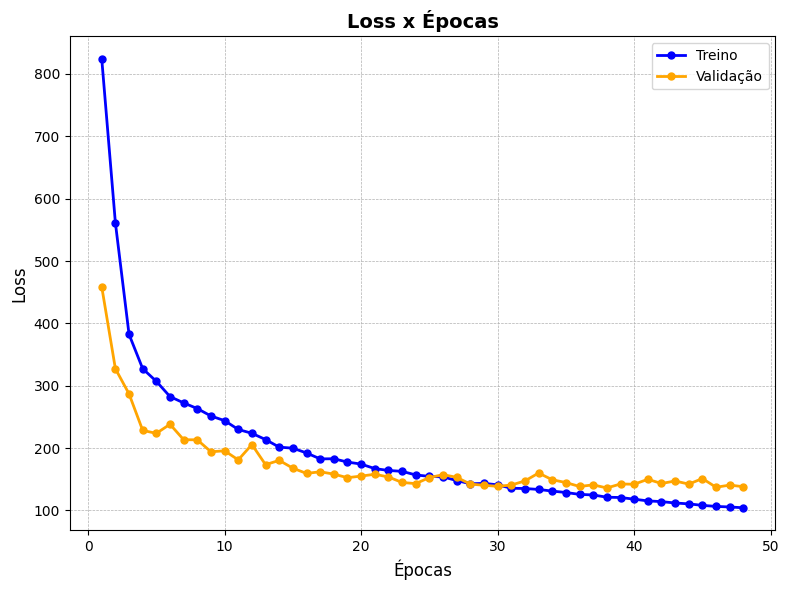

Val loss: 135.9637, Val MAE: 8.9183, Val RMSE: 11.6603
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Saved predictions for fold 4 at /content/drive/MyDrive/00-TCC/hursat/teste/4_pred.csv


Training Fold 5 of 5

Epoch 1/100
648/648 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 1234.8274 - mean_absolute_error: 26.8403 - root_mean_squared_error: 34.2047 - val_loss: 540.6996 - val_mean_absolute_error: 18.3082 - val_root_mean_squared_error: 23.2529
Epoch 2/100
648/648 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - loss: 592.4543 - mean_absolute_error: 19.1016 - root_mean_squared_error: 24.3326 - val_loss: 335.0445 - val_mean_absolute_error: 14.2899 - val_root_mean_squared_error: 18.3042
Epoch 3/100
648/648 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 410.9618 - mean_absolute_error: 15.7244 - root_mean_squared_error: 20.2634 - val_loss: 287.7094 - val_mean_absolute_error: 13.4440 - val_root_mean_squared_error: 16.9620
Epoch 4/100
648/648 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 344.6237 - mean_absolute_error: 14.22

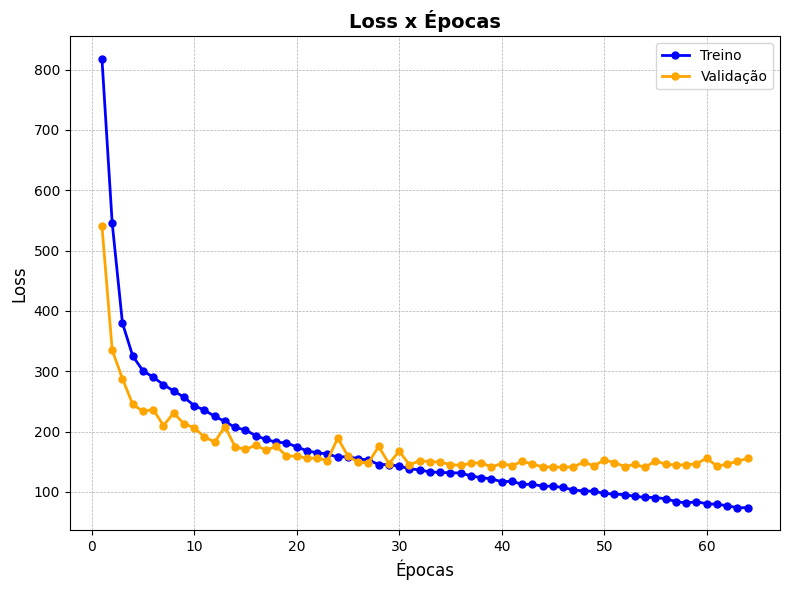

Val loss: 140.5446, Val MAE: 8.9060, Val RMSE: 11.8552
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Saved predictions for fold 5 at /content/drive/MyDrive/00-TCC/hursat/teste/5_pred.csv
Saved all predictions at /content/drive/MyDrive/00-TCC/hursat/teste/all_pred.csv
Saved K-Fold results at /content/drive/MyDrive/00-TCC/hursat/teste/k_fold_result.csv
####### Fold 1 Result #######
Val loss: 141.3038, Val MAE: 9.0028, Val RMSE: 11.8871
####### Fold 2 Result #######
Val loss: 140.0118, Val MAE: 8.9418, Val RMSE: 11.8327
####### Fold 3 Result #######
Val loss: 135.2542, Val MAE: 8.9032, Val RMSE: 11.6299
####### Fold 4 Result #######
Val loss: 135.9637, Val MAE: 8.9183, Val RMSE: 11.6603
####### Fold 5 Result #######
Val loss: 140.5446, Val MAE: 8.9060, Val RMSE: 11.8552


In [14]:
Loss = []
MAE = []
RMSE = []
predictions = pd.DataFrame(columns=['prediction', 'actual', 'abs_error'])

def run_k_fold_cross_validation(n_folds, train_images, train_labels, val_images, val_labels, test_images, test_labels):
    """
    Função principal para executar K-Fold Cross Validation.

    """
    global predictions
    for i in range(n_folds):
        print(f'\n\nTraining Fold {i + 1} of {n_folds}\n')
        model = build_model2()
        model = train_model(model, train_images[i], train_labels[i], val_images[i], val_labels[i])
        evaluate_and_store_metrics(model, i, val_images[i], val_labels[i])
        fold_predictions = generate_and_save_predictions(model, i, test_images, test_labels)
        predictions = pd.concat([predictions, fold_predictions], ignore_index=True)

    save_all_predictions(predictions)
    save_k_fold_results(n_folds)

def evaluate_and_store_metrics(model, fold_index, val_images, val_labels):
    """
    Avalia o modelo e armazena as métricas de perda, MAE e RMSE.

    """
    score = model.evaluate(val_images, val_labels, verbose=0)
    print(f'Val loss: {score[0]:.4f}, Val MAE: {score[1]:.4f}, Val RMSE: {score[2]:.4f}')

    Loss.append(score[0])
    MAE.append(score[1])
    RMSE.append(score[2])

def generate_and_save_predictions(model, fold_index, test_images, test_labels):
    """
    Gera previsões para o fold atual e salva em um arquivo CSV.

    """
    predictions = gera_predicao(model, test_images, test_labels)
    file_path = f'/content/drive/MyDrive/00-TCC/hursat/teste/{fold_index + 1}_pred.csv'
    predictions.to_csv(file_path, index=False)
    print(f'Saved predictions for fold {fold_index + 1} at {file_path}')
    return predictions

def save_all_predictions(predictions_df):
    """
    Salva todas as previsões combinadas em um único arquivo CSV.

    """
    predictions_file = "/content/drive/MyDrive/00-TCC/hursat/teste/all_pred.csv"
    predictions_df.to_csv(predictions_file, index=False)
    print(f'Saved all predictions at {predictions_file}')

def save_k_fold_results(n_folds):
    """
    Gera um DataFrame com os resultados de todos os folds e salva em CSV.

    """
    k_fold_result = {"k_fold": list(range(1, n_folds + 1)), "Loss": Loss, "MAE": MAE, "RMSE": RMSE}
    k_fold_result_df = pd.DataFrame(k_fold_result)
    result_file = "/content/drive/MyDrive/00-TCC/hursat/teste/k_fold_result.csv"
    k_fold_result_df.to_csv(result_file, index=False)
    print(f'Saved K-Fold results at {result_file}')
    for i in range(n_folds):
        print("#" * 7, f"Fold {i + 1} Result", "#" * 7)
        print(f'Val loss: {Loss[i]:.4f}, Val MAE: {MAE[i]:.4f}, Val RMSE: {RMSE[i]:.4f}')

run_k_fold_cross_validation(5, train_images, train_labels, val_images, val_labels, test_images, rotulos_teste)


O menor RMSE é 11.629883766174316, no fold 3
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Forma das predições: (2807, 1)
      Valor Real  Valor Predito  Erro Absoluto       RMSE
1980         105      52.759422      52.240578  52.240578
2574         105      60.049549      44.950451  44.950451
998           85      42.051640      42.948360  42.948360
649          115      73.803841      41.196159  41.196159
1804          15      55.508949      40.508949  40.508949
134           90      49.916042      40.083958  40.083958
80            90      51.857597      38.142403  38.142403
1953         100      63.135384      36.864616  36.864616
1979         110      75.161919      34.838081  34.838081
1259          30      64.562592      34.562592  34.562592
2056          45      79.219933      34.219933  34.219933
2601          50      84.162216      34.162216  34.162216
79           110      76.241470      33.758530  33.758530
1949         115      82.389824      32.610176  32.610176
1473          7

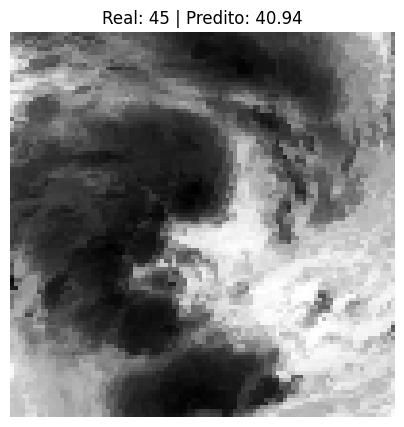

In [24]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import matplotlib.pyplot as plt

def plot_random_image_with_prediction(images, labels_real, labels_pred, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)

    random_index = np.random.randint(0, len(images))
    image = images[random_index].squeeze()
    label_real = labels_real[random_index]
    label_pred = labels_pred[random_index]

    plt.figure(figsize=(5, 5))
    plt.imshow(image, cmap='gray')
    plt.title(f'Real: {label_real} | Predito: {label_pred:.2f}')
    plt.axis('off')
    plt.show()

RMSE = [RMSE[0], RMSE[1], RMSE[2], RMSE[3], RMSE[4]]


min_rmse_index = np.argmin(RMSE)
print(f"O menor RMSE é {RMSE[min_rmse_index]}, no fold {min_rmse_index + 1}")


best_model = tf.keras.models.load_model(f'/content/drive/MyDrive/00-TCC/hursat/teste/{min_rmse_index + 1}_fold_model.keras')


predictions = best_model.predict(test_images)
print(f"Forma das predições: {predictions.shape}")


predictions = predictions.flatten()

abs_errors = abs(predictions - rotulos_teste)
abs_errors_squared = abs_errors ** 2
rmses = np.sqrt(abs_errors_squared)


result_df = pd.DataFrame({
    'Valor Real': rotulos_teste,
    'Valor Predito': predictions,
    'Erro Absoluto': abs_errors,
    'RMSE': rmses
})


result_df = result_df.sort_values(by='Erro Absoluto', ascending=False)
print(result_df.head(100))

rmse_geral = np.sqrt(mean_squared_error(rotulos_teste, predictions))
print(f"RMSE Geral: {rmse_geral}")
plot_random_image_with_prediction(imagens_teste, rotulos_teste, predictions)


In [25]:
import matplotlib.pyplot as plt

def plot_residuos(predicoes, valores_reais):

    residuos = valores_reais - predicoes
    plt.figure(figsize=(10, 6))
    plt.scatter(predicoes, residuos, color='blue')
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Valor Predito')
    plt.ylabel('Resíduo (Real - Predito)')
    plt.title('Plot de Resíduos')
    plt.show()

import seaborn as sns

def plot_histograma_erros(erros_absolutos):

    plt.figure(figsize=(10, 6))
    sns.histplot(erros_absolutos, kde=True, bins=30)
    plt.xlabel('Erro Absoluto')
    plt.ylabel('Frequência')
    plt.title('Histograma dos Erros Absolutos')
    plt.show()

def plot_dispersao_predito_vs_real(predicoes, valores_reais):

    plt.figure(figsize=(10, 6))
    plt.scatter(valores_reais, predicoes, color='blue')
    plt.plot([min(valores_reais), max(valores_reais)], [min(valores_reais), max(valores_reais)], color='red', linestyle='--')
    plt.xlabel('Valor Real')
    plt.ylabel('Valor Predito')
    plt.title('Gráfico de Dispersão (Predito vs. Real)')
    plt.show()

import matplotlib.pyplot as plt

def plot_maiores_erros(result_df, num_erros=30, num_colunas=10):
    """Plota as imagens associadas aos maiores erros preditivos."""

    maiores_erros_df = result_df.sort_values(by='Erro Absoluto', ascending=False).head(num_erros)
    num_linhas = num_erros // num_colunas + (num_erros % num_colunas > 0)
    plt.figure(figsize=(num_colunas * 3, num_linhas * 3))
    for i in range(num_erros):
        img_idx = maiores_erros_df.index[i]
        plt.subplot(num_linhas, num_colunas, i + 1)
        plt.imshow(test_images[img_idx].squeeze(), cmap='gray')
        plt.title(f'Real: {maiores_erros_df.iloc[i]["Valor Real"]}\nPredito: {round(maiores_erros_df.iloc[i]["Valor Predito"], 1)}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


import matplotlib.pyplot as plt

def plot_maiores_acertos(result_df, num_acertos=30, num_colunas=10):
    """Plota as imagens associadas aos menores erros preditivos (maiores acertos)."""

    maiores_acertos_df = result_df.sort_values(by='Erro Absoluto', ascending=True).head(num_acertos)
    num_linhas = num_acertos // num_colunas + (num_acertos % num_colunas > 0)
    plt.figure(figsize=(num_colunas * 3, num_linhas * 3))

    for i in range(num_acertos):
        img_idx = maiores_acertos_df.index[i]

        plt.subplot(num_linhas, num_colunas, i + 1)
        plt.imshow(test_images[img_idx].squeeze(), cmap='gray')
        plt.title(f'Real: {maiores_acertos_df.iloc[i]["Valor Real"]}\nPredito: {round(maiores_acertos_df.iloc[i]["Valor Predito"], 1)}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

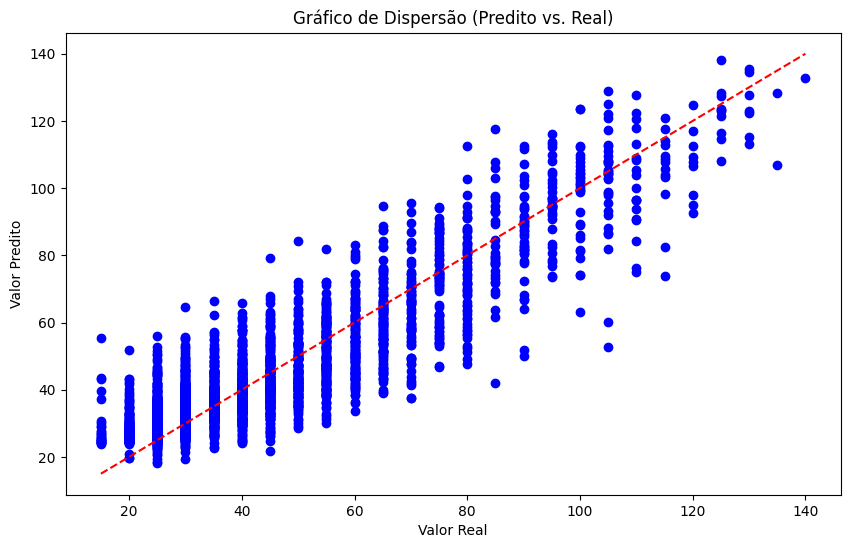

In [26]:
plot_dispersao_predito_vs_real(predictions, rotulos_teste)

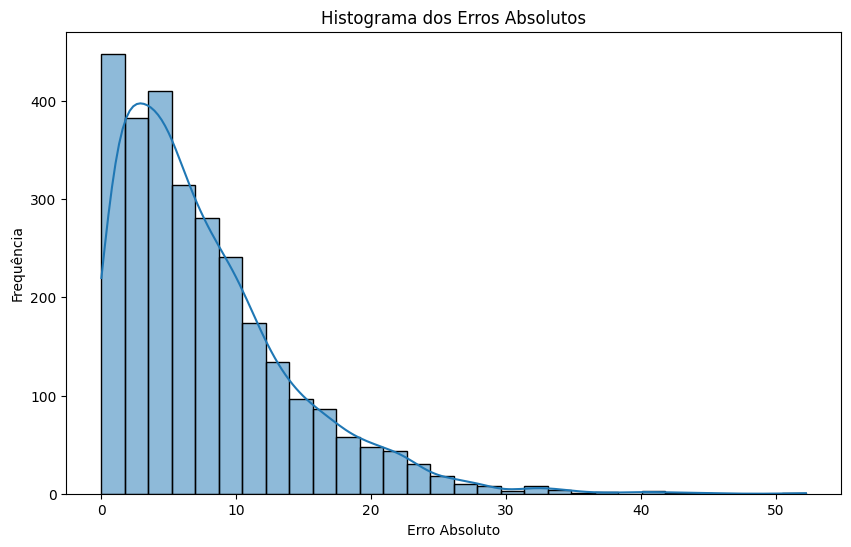

In [27]:
plot_histograma_erros(abs_errors)

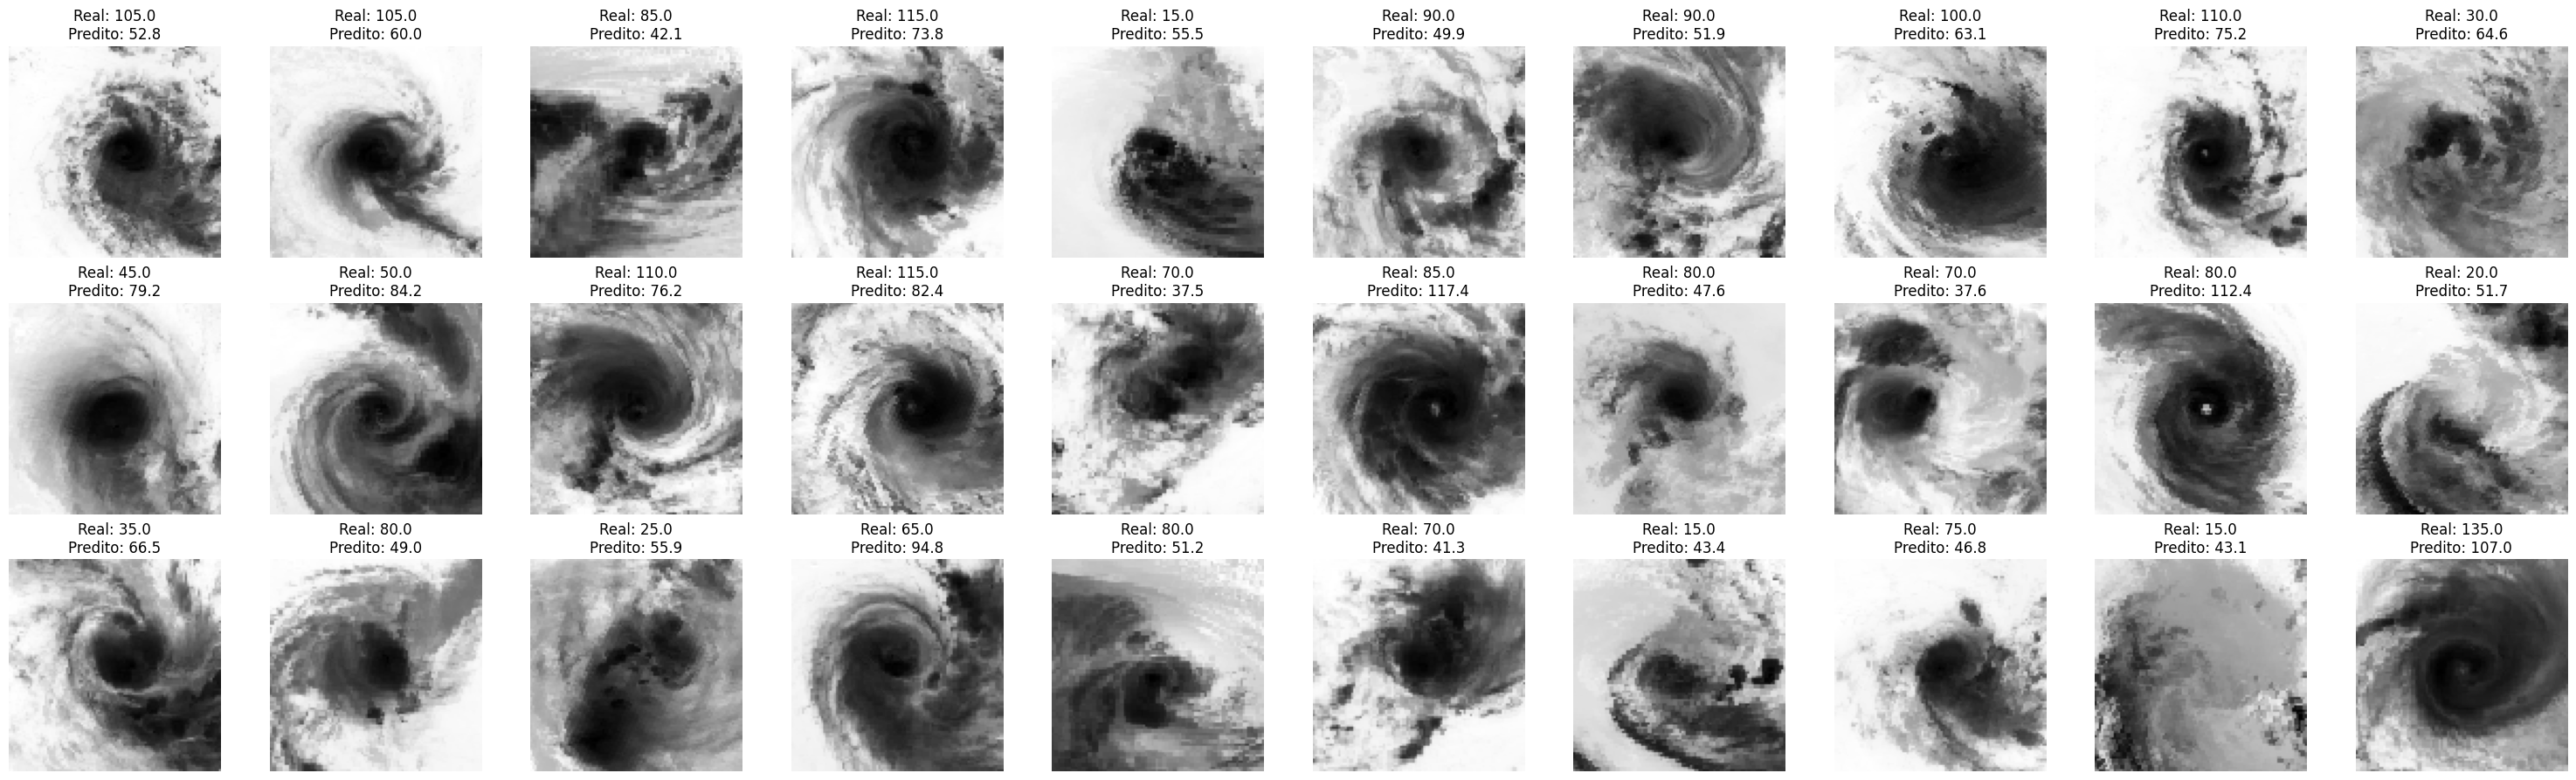

In [28]:
plot_maiores_erros(result_df)

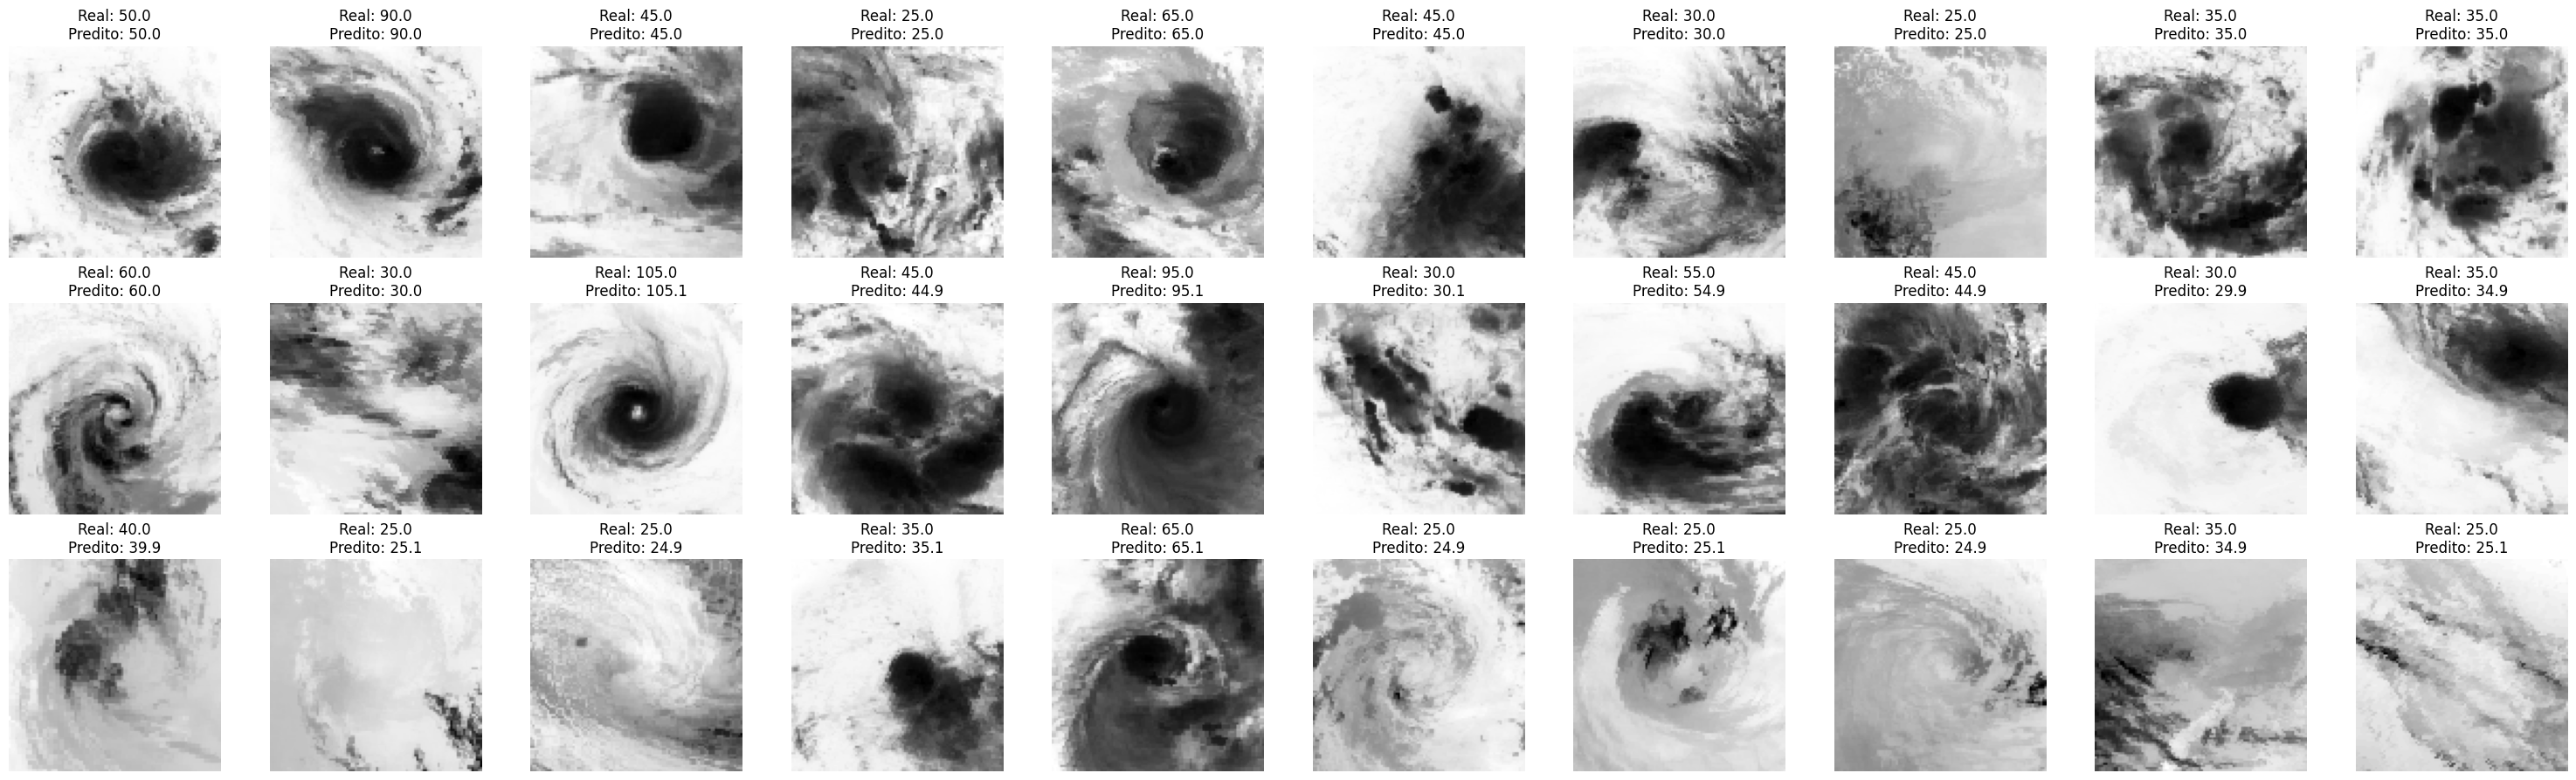

In [29]:
plot_maiores_acertos(result_df)

Imagem 1 - Shape: (100, 100)
Imagem 2 - Shape: (100, 100)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
Forma das predições: (2, 1)
   Valor Real  Valor Predito  Erro Absoluto       RMSE
1         145     117.649590      27.350410  27.350410
0          35      36.286465       1.286465   1.286465
RMSE Geral: 19.36104263476112


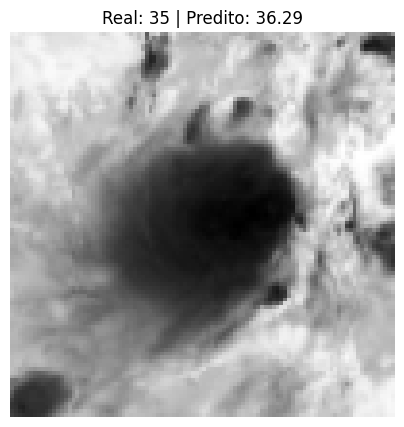

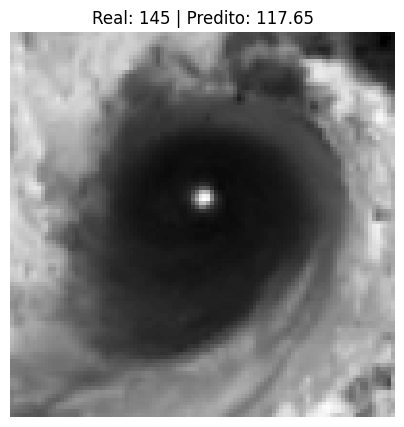

In [30]:

import numpy as np
from PIL import Image
import os

def load_image_as_numpy_array(image_path):
    img = Image.open(image_path)
    img = img.convert('L')
    img = img.resize((100, 100))
    img_array = np.array(img)

    return img_array

image_folder = '/content/drive/MyDrive/00-TCC/hursat/milton'

image_files = ['milton-35-2.png', 'milton-145.png']

labels = [35, 145]
labels_milton = np.array(labels)

images_milton = []

for image_file in image_files:
    image_path = os.path.join(image_folder, image_file)
    image_array = load_image_as_numpy_array(image_path)
    images_milton.append(image_array)

for idx, image_array in enumerate(images_milton):
    print(f"Imagem {idx+1} - Shape: {image_array.shape}")


images_milton = np.array(images_milton).reshape(-1, 100, 100, 1)
Xmilton, images_milton = normaliza_dados(images_milton, images_milton)
predictions = best_model.predict(images_milton)
print(f"Forma das predições: {predictions.shape}")


predictions = predictions.flatten()
abs_errors = abs(predictions - labels_milton)
abs_errors_squared = abs_errors ** 2
rmses = np.sqrt(abs_errors_squared)

result_df = pd.DataFrame({
    'Valor Real': labels_milton,
    'Valor Predito': predictions,
    'Erro Absoluto': abs_errors,
    'RMSE': rmses
})


result_df = result_df.sort_values(by='Erro Absoluto', ascending=False)
print(result_df.head(100))
rmse_geral = np.sqrt(mean_squared_error(labels_milton, predictions))
print(f"RMSE Geral: {rmse_geral}")

def plot_images_with_predictions(images, labels_real, labels_pred):
    for i in range(len(images)):
        image = images[i].squeeze()
        label_real = labels_real[i]
        label_pred = labels_pred[i]

        plt.figure(figsize=(5, 5))
        plt.imshow(image, cmap='gray')
        plt.title(f'Real: {label_real} | Predito: {label_pred:.2f}')
        plt.axis('off')
        plt.show()

plot_images_with_predictions(images_milton, labels_milton, predictions)